# Chapter 3 - 分類問題 : scikit-learnを活用する

この章では, 以下について勉強する:

- よく使用されている分類アルゴリズムの概念
- scikit-learnライブラリの使用法
- 機械学習アルゴリズムの選択方法について

## 分類アルゴリズムの選択

- **No Free Lunch 定理** (Wolpert, Macready. 1997): 任意の組み合わせ最適化問題に対して, 最良な最適化手法は存在しない.
    - 機械学習の文脈では, 「データの分布などに関する予備知識 (事前知識) がないと, どの問題に対しても最良なアルゴリズムは存在しない」という意味合い.
- いくつかの学習アルゴリズムの性能を比較し, 特定の問題に最適なモデルを選択することが重要.
- 機械学習のアルゴリズムのトレーニングを構成する, 主要な5ステップ:
    1. 特徴量を選択する.
    2. 性能指標を選択する.
    3. 分類器と最適化アルゴリズムを選択する.
    4. モデルの性能を評価する.
    5. アルゴリズムを調整する.

## scikit-learnを使ったパーセプトロンのトレーニング

Fisherのアヤメデータセットを用いる.

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [3]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


トレーニングされたモデルの性能を未知のデータで評価するため, データセットを70%のトレーニングデータと30%のテストデータに分割する.
以下の操作で, 配列 `X` と配列 `y` を, トレーニングデータとテストデータにランダムに分割している.

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

アルゴリズムの最適性能を得るために, 標準化によりスケーリングする.

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

`sc.fit()` で, トレーニングデータから特徴量ごとに平均値 $\mu$, 標準偏差 $\sigma$ を推定している.
`sc.transform` で, 推定されたパラメータ $\mu, \sigma$ を用いて標準化を行っている.
テストデータとトレーニングデータを比較できるようにするため, テストデータの標準化もトレーニングデータから推定したパラメータで行う.

パーセプトロンモデルをトレーニングしてみる.

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

`eta0` は学習率であり, 調整が必要な場合がある.
エポックごとにトレーニングデータセットの並べ替えができるよう, `random_state` パラメータを利用している.

トレーニングを行ったので, テストデータで予測をしてみる.

In [7]:
y_test.shape

(45,)

テストデータは45個ある.

In [8]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 4


うち, 誤分類されたのは4個であった.
モデルの正解率 (accuracy) は, 次のように計算できる:
$$
    \text{Accuracy} = 1 - \text{誤分類率}.
$$
計算をしてみる.

In [9]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.91


決定領域を図示してみる.

In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

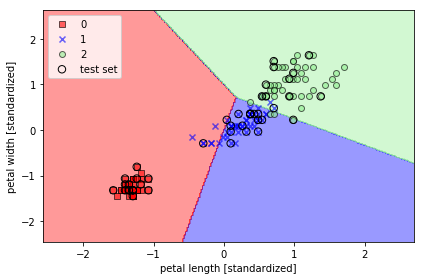

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()

三つの品種を線形の決定境界で完全に区別することはできない.
完全な線形分離が不可能なデータセットでは, パーセプトロンアルゴリズムは決して収束しないので, 使うのは厳しい.

以降では, クラスが完全に線形分離できない場合でもコストの最小値に収束する, より強力な線形分類器を扱う.

## ロジスティック回帰を用いたクラスの確率のモデリング

- **ロジスティック回帰** (logistic regression): 分類モデルの一つ. 線形分離可能なクラスに対してのみ, 高い性能を発揮する.
- **オッズ比** (odds ratio): 事象の起こりやすさを表すもの. $p$ を正事象 (i.e., 予測したい事象) の起こる確率とすると, オッズ比は
    $$
        \frac{p}{1-p}
    $$
    と表される.
- **ロジット関数** (logit function): 対数オッズ:
    $$
        \mathop{logit}(p) \triangleq \log \frac{p}{1-p}.
    $$
    - $\mathop{logit}: (0,1) \to \mathbb{R}$.
    - この関数を使って, 特徴量の値と対数オッズの間の線形関係を表すことができる:
    $$
        \mathop{logit}(P(y = 1 | x)) = w^{\top}x.
    $$
- やりたいこと: サンプル $x$ が特定のクラス $y = 1$ に属している確率 $p(y = 1 | x)$ を求めること.
    - **ロジスティック関数** (logistic function), あるいは **シグモイド関数** (sigmoid function): ロジット関数の逆関数:
    $$
        \phi(z) = \mathop{logit}\nolimits^{-1}(z) \triangleq \frac{1}{1 + e^{-z}}.
    $$
    - $\mathop{logit}\nolimits^{-1}: \mathbb{R} \to (0,1)$.

7以上7未満の範囲にある値のシグモイド関数をプロットしてみる.

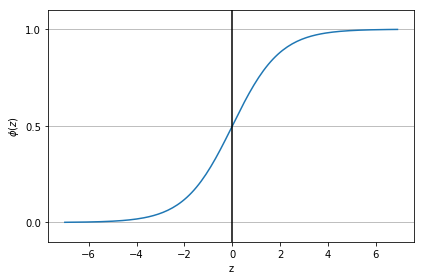

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('./figures/sigmoid.png', dpi=300)
plt.show()

- シグモイド関数の特徴
    - $\phi(z) \to 1$ as $z \to \infty$.
    - $\phi(z) \to 0$ as $z \to -\infty$.
    - $\phi(0) = \frac{1}{2}$.

- ロジスティック回帰は, ADALINEでの活性化関数 (恒等関数であった) を, シグモイド関数に変更したもの.
- 特徴量 $x$ が, 重み $w$ でパラメータ化されるとすれば, $\phi (w^{\top}x) = P(y=1 | x; w)$ であるから, シグモイド関数の出力する値は $x$ がクラス1に属している確率.
- 量子化器で, 確率が0.5以上ならばクラス $1$に, 0.5未満ならばクラス $0$ に属するように判定すればよい, i.e., 
    $$
        \hat{y} = \begin{cases} 1, & w^{\top}x \ge 0 \\ 0. & w^{\top}x < 0 \end{cases}
    $$

予測されるクラスラベルだけでなく, **そのクラスに属する確率が計算できる**という点が有用.

### ロジスティック関数の重みの学習

- データセットのサンプルが互いに独立であると仮定する.
- コスト関数
    $$
        J(w) = \frac{1}{2} \| \phi(w^{\top}x) - y \|^2
    $$
  を最小にする $w$ を求めるのでなく, 次の **尤度** (likelihood) $L(w)$ を最大にする $w$ を求めるようにする:
    $$
        L(w) \triangleq P(y | x; w) = \prod_{i=1}^n P(y^{(i)} | x^{(i)}; w) = \prod_{i=1}^n (\phi(w^{\top} x^{(i)}))^{y^{(i)}} (1 - \phi(w^{\top} x^{(i)}))^{1- y^{(i)}}.
    $$
    - $P(y | x; w) = \prod_{i=1}^n P(y^{(i)} | x^{(i)}; w)$ はサンプルの独立性から.
- 実際には, **対数尤度** (log-likelihood) を最大化するほうが簡単:
    $$
        l(w) \triangleq \log L(w) = \sum_{i=1}^n \left( y^{(i)} \log \phi (w^{\top} x^{(i)}) + (1-y^{(i)}) \log (1- \phi(w^{\top} x^{(i)})) \right).
    $$
- 結局, 最小化するコスト関数として, 以下を用いればよい:
    $$
        J(w) = - l(w) = -\sum_{i=1}^n \left( y^{(i)} \log \phi (w^{\top} x^{(i)}) + (1-y^{(i)}) \log (1- \phi(w^{\top} x^{(i)})) \right).
    $$

一つのサンプルで計算されるコストを見てみる.
$$
    J(w) = - \left( y \log \phi (z) + (1-y) \log (1- \phi(z) \right) = \begin{cases} -\log \phi (z), & y = 1 \\ -\log (1- \phi(z)). & y = 0 \end{cases}
$$

これをプロットしてみると次の通り.

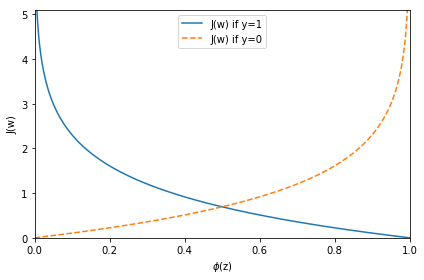

In [13]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/log_cost.png', dpi=300)
plt.show()

- サンプルがクラス $1$ に属していることを正しく予測した場合, i.e., $\phi(z) \ge 0.5$ のとき: コストは0に近い.
- サンプルがクラス $0$ に属していることを正しく予測した場合, i.e., $\phi(z) < 0.5$ のとき: コストは0に近い.
- サンプルが間違って予測した場合は, コストは大きくなる.

### scikit-learnによるロジスティック回帰モデルのトレーニング

とりあえず, scikit-learnを使ってロジスティック回帰してみる.

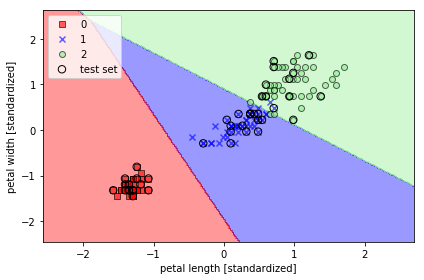

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

なお, サンプルの所属関係の確率を予測することもできる.

In [15]:
if Version(sklearn_version) < '0.17':
    print(lr.predict_proba(X_test_std[0, :]))
else:
    print(lr.predict_proba(X_test_std[0, :].reshape(1, -1)))

[[  2.05743774e-11   6.31620264e-02   9.36837974e-01]]


勾配降下法に基づくロジスティック回帰での重みの更新は, ADALINEでの重みの更新で活性化関数を恒等関数からシグモイド関数に取り換えたものであることを確認する.

$$
    \frac{\partial}{\partial w} J(w) = - \frac{\partial}{\partial w} l(w) = - \sum_{i=1}^n \left( y^{(i)} \frac{1}{\phi (w^{\top} x^{(i)})} - (1-y^{(i)}) \frac{1}{1- \phi(w^{\top} x^{(i)})} \right) \frac{\partial}{\partial w} \phi(w^{\top} x^{(i)}).
$$

ここで, 
$$
    \frac{\partial}{\partial w} \phi(w^{\top} x^{(i)}) = x^{(i)} \frac{\partial}{\partial z} \phi(z)
$$
であり, 
$$
    \frac{\partial}{\partial z} \phi(z) = \frac{\partial}{\partial z} \frac{1}{1 + e^{-z}} = \frac{e^{-z}}{(1 + e^{-z})^2} = \phi(z)(1- \phi(z))
$$
であるから, 
$$
    \frac{\partial}{\partial w} J(w) = - \sum_{i=1}^n \left( y^{(i)} \frac{1}{\phi (w^{\top} x^{(i)})} - (1-y^{(i)}) \frac{1}{1- \phi(w^{\top} x^{(i)})} \right) \phi(w^{\top} x^{(i)})(1- \phi(w^{\top} x^{(i)})) x^{(i)} \\
    = - \sum_{i=1}^n \left( y^{(i)}(1- \phi(w^{\top} x^{(i)})) - (1-y^{(i)})\phi(w^{\top} x^{(i)})\right) x^{(i)} \\
    = - \sum_{i=1}^n \left( y^{(i)}- \phi(w^{\top}x^{(i)})\right) x^{(i)}.
$$
結局, 重みの更新は
$$
    w := w + \Delta w, ~~ \Delta w = - \eta \nabla J(w) = - \eta \sum_{i=1}^n \left( y^{(i)}- \phi(w^{\top}x^{(i)})\right) x^{(i)}
$$
となる.

ADALINEでも, $\nabla J(w) = \sum_{i=1}^n \left( y^{(i)}- \phi(w^{\top}x^{(i)})\right) x^{(i)}$ となっていたので, 更新式は同じであり, 活性化関数 $\phi$ のみ異なっていることがわかる.

## 正則化による過学習への対処

- **過学習** (overfitting): トレーニングデータセットではうまく機能するモデルが, テストデータセットではうまく汎化されないという問題.
  **バリアンスが高い**とも表現される.
    - 原因: パラメータ数が多すぎるため, データに対してモデルが複雑すぎる.
- **学習不足** (underfitting): トレーニングデータセットのパターンをうまく捕捉するには, モデルの複雑さが不十分で, テストデータセットに対する性能が低いという問題. **バイアスが高い**とも表現される.

### バイアスとバリアンス

- **バリアンス** (variance): モデルのトレーニングを繰り返した場合に, モデルの予測の一貫性 (あるいはその逆のばらつき)を定量化する指標.
    - モデルを異なるトレーニングデータセットで構築した複数のモデルによる, 予測値の平均まわりでのばらつきの期待値.
    - バリアンスが小さいほど予測値はばらつかず, 大きいほど予測値はばらつく.
    - バリアンスが高いとは, トレーニングデータセットの選び方によって, 予測結果がばらついてしまう状況を指す.
        - トレーニングデータセットのランダム性に対して敏感になる.
- **バイアス** (bias): モデルを異なるトレーニングデータセットで構築した複数のモデルによる予測値の平均が, 真値からどの程度離れているかを定量化する指標.
    - 系統誤差 (同じ方法を用いて測定すると, 真値に対して系統的にずれて測定される誤差) の測定値.
    - 小さいほど, 平均的な意味で真値に近く, 大きいほど平均的な意味で真値から遠ざかる.
- 一般に, モデルの汎化誤差は次式のように分解される:
$$
    \text{モデルの汎化誤差} = (\text{バイアス})^2 + \text{バリアンス} + \text{ノイズ}.
$$
- **バイアスとバリアンスのトレードオフ**: バイアスを小さくするとバリアンスが大きくなり, バリアンスを小さくするとバイアスが大きくなる.

### 正則化

バイアスとバリアンスにはトレードオフがある.<br />
→ どの程度複雑なモデルにすれば, ちょうどいいモデルの複雑さになるのか?

- **正則化** (regularization): 特徴量の間の相関の高さ, i.e., **共線性** (collinearity) を処理する手法. データからノイズを取り除き, 最終的に過学習を防ぐ.
    - 極端なパラメータの重みにペナルティを科すための追加情報 (バイアス) を導入する, i.e,, 最小化するべきコスト関数に, 正則化項を追加することで正則化を行う.
    - **L2正則化** (L2 regularization): $\lambda$ を正則化パラメータとして, 正則化項が 
    $$
        \frac{\lambda}{2} \| w \|^2
    $$
    となっているもの.
    - 正則化を正常に機能させるには, すべての特徴量が比較可能な尺度になるように, 標準化などでスケーリングをすることが重要.

先述のロジスティック回帰でL2正則化を行うときは, コスト関数は次のようにする:
$$
    J(w) = -\sum_{i=1}^n \left( y^{(i)} \log \phi (w^{\top} x^{(i)}) + (1-y^{(i)}) \log (1- \phi(w^{\top} x^{(i)})) \right) + \frac{\lambda}{2} \| w \|^2.
$$
正則化パラメータ $\lambda$ を使用することで, 重みを小さく保ちながらトレーニングデータセットをどの程度適合させるのかを制御できる.
正則化の強さを高めるには, $\lambda$ の値を大きくすればよい.

scikit-learnの `LogisticRegression` クラスに実装されているパラメータ `C` は逆正則化パラメータであり, 上式の正則化パラメータ $\lambda$ の逆数である:
$$
    C = \frac{1}{\lambda}.
$$
上のロジスティック回帰のコスト関数 $J(w)$ を最小化することは, $C J(w)$ を最小化することと同値であるから, 改めてコスト関数 $J(w)$ を
$$
    J(w) = -C \sum_{i=1}^n \left( y^{(i)} \log \phi (w^{\top} x^{(i)}) + (1-y^{(i)}) \log (1- \phi(w^{\top} x^{(i)})) \right) + \frac{1}{2} \| w \|^2
$$
としてもよい.

正則化の強さを可視化するために, 二つの重み係数と逆正則化パラメータ $C$ の関係をプロットすればよい.

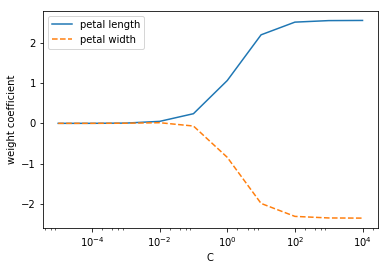

In [16]:
weights, params = [], []
for c in np.arange(-5., 5.):
    lr = LogisticRegression(C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('./figures/regression_path.png', dpi=300)
plt.show()

$C$ が小さくなるにつれて, 重み係数が0に近づいていくことが確認できる.

## サポートベクトルマシンによる最大マージン分解

- **サポートベクトルマシン** (Support Vector Machine: SVM): パーセプトロンの拡張.
    - **マージン** (margin): 決定境界 (超平面)と, この超平面に最も近いトレーニングサンプル (**サポートベクトル**) との間の距離.
    - SVM: マージンを最大化する.
        - パーセプトロン: 誤分類率を最小化した.
    - マージンの大きいモデルは汎化誤差が小さい傾向にあるが, マージンが小さいと過学習に陥りがち.

### 最大マージンに関して

決定境界に沿った, 正の超平面
$$
    w_0 + w^{\top}x_{\text{pos}} = 1
$$
と, 負の超平面
$$
    w_0 + w^{\top}x_{\text{neg}} = -1
$$
を考える.
辺々引くと, 
$$
    w^{\top}(x_{\text{pos}} - x_{\text{neg}}) = 2.
$$
両辺 $\| w \|$ で割ると, 
$$
    \frac{w^{\top}(x_{\text{pos}} - x_{\text{neg}})}{\| w \|} = \frac{2}{\| w \|}.
$$
この左辺は, 正の超平面と負の超平面の距離, i.e., 最大化したいマージン (の2倍) であると解釈できる.
結局, サンプルが正しく分類されている, i.e., 
$$
    w_0 + w^{\top}x^{(i)} \ge 1, ~~ y^{(i)} = 1\\
    w_0 + w^{\top}x^{(i)} \le -1, ~~ y^{(i)} = -1\\
$$
より簡潔には,
$$
    y^{(i)}(w_0 + w^{\top}x^{(i)}) \ge 1, ~~ \forall i \in \{1, \dots, n\}
$$
が成り立つという制約の下でSVMの目的関数
$$
    \frac{w^{\top}(x_{\text{pos}} - x_{\text{neg}})}{\| w \|}
$$
を最大化する問題は, 
$$
    \frac{2}{\| w \|}
$$
を最大化する問題と同値である.
これは, $\| w \|$ を最小化する, さらには $\frac{1}{2} \| w \|^2$ を最小化する問題と同値であり, こちらのほうが二次計画問題になっているため扱いやすい.
よって, 以下の二次計画問題を解けばよい:
$$
    \min ~~ \frac{1}{2} \| w \|^2 \\
    \text{s.t.} ~~ y^{(i)}(w_0 + w^{\top}x^{(i)}) \ge 1, ~~ \forall i \in \{1, \dots, n\}.
$$

### スラック変数を使った非線形分離可能なケースへの対処

非線形分離可能なデータを扱うためには, 線形制約を緩和する必要がある.
そのためには, スラック変数 $\xi^{(i)}$ と定数 $C$ を導入して, 
$$
    \min ~~ \frac{1}{2} \| w \|^2 + C\left( \sum_{i=1}^{n} \xi^{(i)} \right)\\
    \text{s.t.} ~~ y^{(i)}(w_0 + w^{\top}x^{(i)}) \ge 1 - \xi^{(i)}, ~~ \forall i \in \{1, \dots, n\}\\
    \xi^{(i)} \ge 0, ~~ \forall i \in \{1, \dots, n\}
$$
を解く.
ここで, $C\left( \sum_{i=1}^{n} \xi^{(i)} \right)$ の項を最小化する目的関数に導入しているのは, これが誤分類の程度を表しているからである:

- $\xi^{(i)}$ は, $i$ 番目のサンプルに対して線形制約を緩和するために導入されている.
- 誤分類が生じるときは, $\xi^{(i)} > 1$ となるから, $K \in \mathbb{Z}_{>0}$ として $\sum_{i=1}^{n} \xi^{(i)} \le K$ ならば, 誤分類したサンプルの数が $K$ 個以下であることが示せる.

定数 $C$ は, 誤分類のペナルティを制御するためのハイパーパラメータである.

- $C$ が大きい: 誤分類のペナルティが大きい.
- $C$ が小さい: 誤分類のペナルティが小さい.

→ $C$ でマージンの幅を制御できるので, バイアスとバリアンスのトレードオフを調整できる.

SVMモデルをトレーニングして, アヤメデータセットの分類を行ってみる.

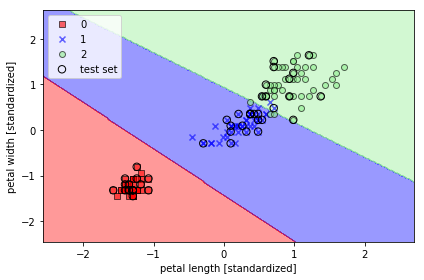

In [17]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_linear.png', dpi=300)
plt.show()

線形ロジスティック回帰と, 線形SVMの結果は似たようなものになることが多い.

- ロジスティック回帰: トレーニングデータセットの条件付き尤度を最大化する.
    - SVMより外れ値の影響を受けやすい.
    - SVMより実装しやすく, 単純なモデル.
    - 簡単に更新できるため, ストリーミングデータを扱うときに便利.
- SVM: 決定境界に最も近い点に興味がある.

### scikit-learnでの代替実装

データが大きすぎて, コンピュータのメモリに収まらない場合は, 確率的勾配降下法を使って以下のように書くとよい.

```
    from sklearn.linear_model import SGDClassifier
    
    # 確率的勾配降下法バージョンのパーセプトロン
    ppn = SGDClassifier(loss = `perceptron`)
    
    # 確率的勾配降下法バージョンのロジスティック回帰
    lr = SGDClassifier(loss = `log`)
    
    # 確率的勾配降下法バージョンのSVM (損失関数がヒンジ関数)
    svm = SGDClassifier(loss = `hinge`)
```

## カーネルSVMを用いた非線形問題の求解

- **カーネルSVM** (kernel SVM): SVMを, 非線形問題を解くために「カーネル化」したもの.

まずは, 非線形分類問題がどのようなものか, サンプルデータセットを生成してみる.

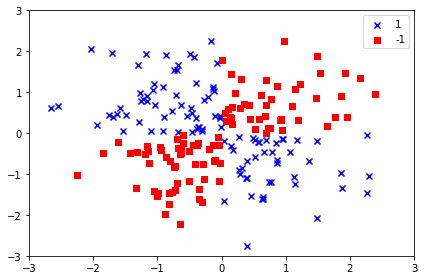

In [18]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

このデータセットでは, 線形ロジスティック回帰, 線形SVMは利用できない.

**カーネル手法の基本的発想**: 射影関数 $\phi$ を用いて, データの組み合わせを高次元空間へ射影し, 線形分離できるようにする.

高次元空間で線形SVMモデルをトレーニングすれば分類できる.

### カーネルトリックを使って分離超平面を高次元空間で特定する

- $\phi$ で高次元空間に射影し, 線形SVMモデルをトレーニングすれば, テストデータも $\phi$ で射影することで分類できる.<br />
    → 次元が高いと, 新しい特徴量を生成するコストが高くなってしまう.
- **カーネルトリック** (kernel trick): $\phi$ を用意するのではなく, サンプルごとの内積の値を返す **カーネル関数**
    $$
        k(x^{(i)}, x^{(j)}) \triangleq \phi(x^{(i)})^{\top} \phi(x^{(j)})
    $$
    を用いることで計算コストを削減する.
    - 最も広く使用されるカーネル: **動径基底関数カーネル** (Radial Basis Function kernel: RBF kernel)
    $$
        k(x^{(i)}, x^{(j)}) = \exp \left( - \frac{\| x^{(i)} - x^{(j)} \|^2}{2\sigma^2} \right) = \exp \left( - \gamma \| x^{(i)} - x^{(j)} \|^2 \right).
    $$
        - $\gamma = \frac{1}{2\sigma^2}$ は, 最適化されるハイパーパラメータ.
        - $\gamma$ は, このカーネル関数の「カットオフ」パラメータ: 
            - $\gamma$ が小さい: トレーニングサンプルの影響力大 → 決定境界がなめらか.
    - カーネル関数: 二つのサンプル間の類似性を表す関数.

カーネルSVMをトレーニングしてみる.

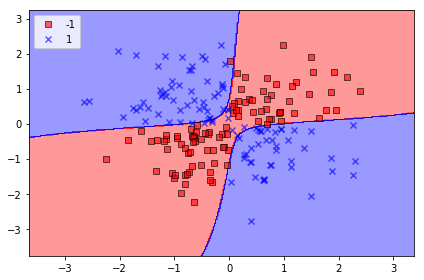

In [19]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_xor.png', dpi=300)
plt.show()

いい感じに分類できている.

アヤメデータセットでもやってみる.

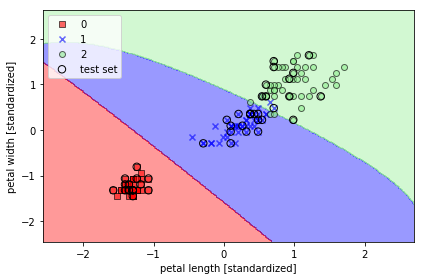

In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_1.png', dpi=300)
plt.show()

$\gamma$ が小さいので, 決定境界がなめらか. $\gamma$ が大きくなるとどうなるか?

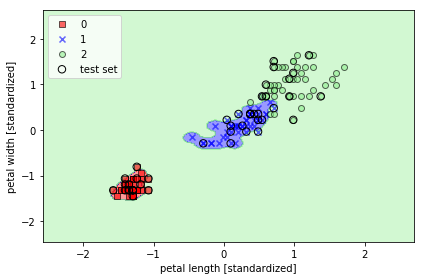

In [21]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_2.png', dpi=300)
plt.show()

$\gamma$ が大きいと, クラス0とクラス1の周りの決定境界がかなり複雑になる.
このモデルは, 汎化誤差が大きくなってしまうことが考えられる.

ハイパーパラメータ $\gamma$ の最適化がモデルにとって重要である.

## 決定木学習

- **決定木** (decision tree): 得られた結果の意味を解釈しやすいかどうか, i.e., **意味解釈可能性** (interpretability) に配慮する場合に有用なモデル.
    - トレーニングデータセットの特徴量に基づいて一連の質問を学習し, その一連の質問に基づいて決断を下すことでデータを分類する.
    - 決定木の根からはじめて, 分割された集合の要素についてのばらつきの減少, i.e., **情報利得** (information gain) が最大となる特徴量でデータを分割する.
        - 決定木の葉が純粋になる, i.e., 分割されたデータのばらつきの減少がなくなり, そのデータがすべて同じクラスに属するようになるまで, この分割を分岐条件ごとに繰り返す.
        - 実際には, 葉が純粋になるまで分割をくりかえすと多くのノードを持つ深い決定木になるので, 過学習に陥る.
        - ふつうは決定木の最大の深さに制限を付けて, 決定木を **剪定** (prune) する.

### 情報利得の最大化

